In [8]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn; seaborn.set()
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

In [10]:
data = pd.read_csv('btc_price.csv', index_col="Date")

data.tail()

,Close,Volume,Market Cap
Date,,,
"May 12, 2018",8504.89,6821380000,1.437430e+11
"May 13, 2018",8723.94,5866380000,1.450220e+11
"May 14, 2018",8716.79,7364150000,1.484030e+11
"May 15, 2018",8510.38,6705710000,1.482830e+11
"May 16, 2018",0.00,0,0.000000e+00


In [12]:
#Tranform the date field

data.index = pd.to_datetime(data.index)
print(data.index)
data.head(5)

DatetimeIndex(['2015-08-07', '2015-08-08', '2015-08-09', '2015-08-10',
               '2015-08-11', '2015-08-12', '2015-08-13', '2015-08-14',
               '2015-08-15', '2015-08-16',
               ...
               '2018-05-07', '2018-05-08', '2018-05-09', '2018-05-10',
               '2018-05-11', '2018-05-12', '2018-05-13', '2018-05-14',
               '2018-05-15', '2018-05-16'],
              dtype='datetime64[ns]', name='Date', length=1014, freq=None)


,Close,Volume,Market Cap
Date,,,
2015-08-07,279.59,42484800,4.032820e+09
2015-08-08,261.00,58533000,4.048270e+09
2015-08-09,265.08,23789600,3.779770e+09
2015-08-10,264.47,20979400,3.843850e+09
2015-08-11,270.39,25433900,3.828500e+09


Text(0,0.5,'Daily Bitcoin price')

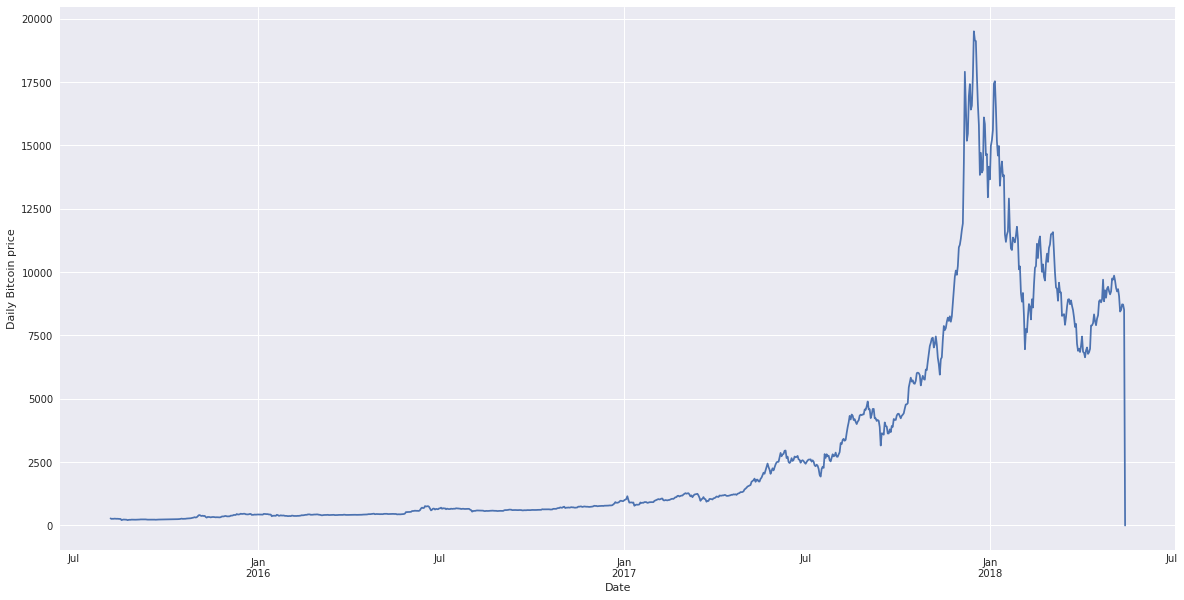

In [14]:
data['Close'].plot(figsize=(20,10))
plt.ylabel("Daily Bitcoin price")

Date
1    AxesSubplot(0.125,0.2;0.775x0.68)
2    AxesSubplot(0.125,0.2;0.775x0.68)
3    AxesSubplot(0.125,0.2;0.775x0.68)
4    AxesSubplot(0.125,0.2;0.775x0.68)
Name: Close, dtype: object

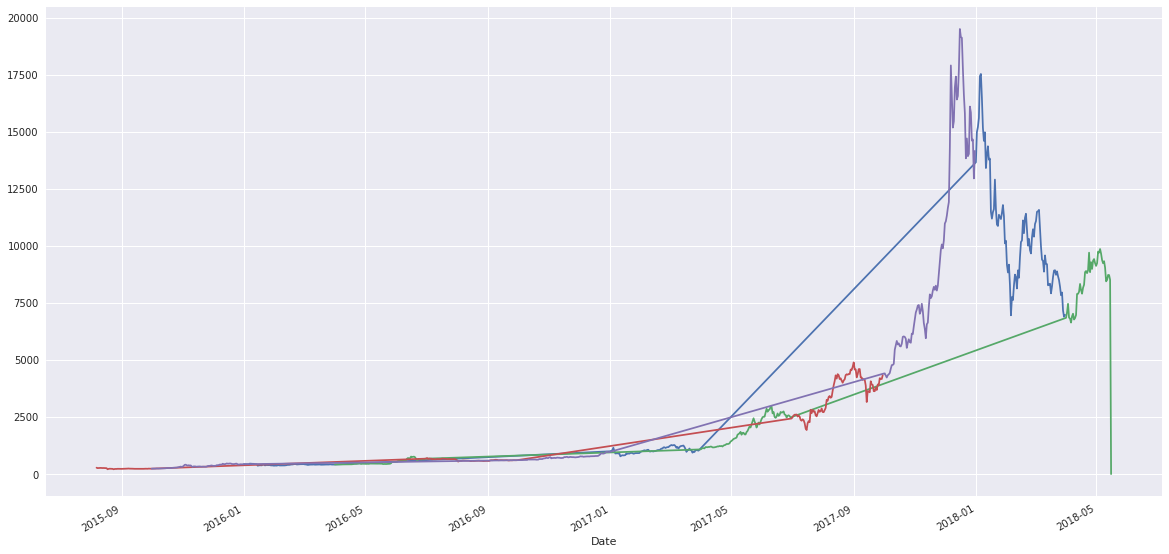

In [16]:
data1 = data['Close']

by_quarter = data1.groupby(data1.index.quarter)
by_quarter.plot(figsize=(20,10))

In [18]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [42]:
# load dataset
dataset1 = data[['Close','Volume','Market Cap']]
values = dataset1.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.014340   0.001782   0.012371  0.013386
2   0.013386   0.002455   0.012418  0.013596
3   0.013596   0.000998   0.011594  0.013564
4   0.013564   0.000880   0.011791  0.013868
5   0.013868   0.001067   0.011744  0.013662


In [43]:
# split into train and test sets
values = reframed.values
n_train_hours = int(len(values)*0.5)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(506, 1, 3) (506,) (507, 1, 3) (507,)


Train on 506 samples, validate on 507 samples
Epoch 1/50
 - 1s - loss: 0.0044 - val_loss: 0.2369
Epoch 2/50
 - 0s - loss: 0.0067 - val_loss: 0.2107
Epoch 3/50
 - 0s - loss: 0.0091 - val_loss: 0.2078
Epoch 4/50
 - 0s - loss: 0.0062 - val_loss: 0.1938
Epoch 5/50
 - 0s - loss: 0.0061 - val_loss: 0.1795
Epoch 6/50
 - 0s - loss: 0.0061 - val_loss: 0.1601
Epoch 7/50
 - 0s - loss: 0.0090 - val_loss: 0.1627
Epoch 8/50
 - 0s - loss: 0.0053 - val_loss: 0.1466
Epoch 9/50
 - 0s - loss: 0.0061 - val_loss: 0.1350
Epoch 10/50
 - 0s - loss: 0.0059 - val_loss: 0.1216
Epoch 11/50
 - 0s - loss: 0.0063 - val_loss: 0.1169
Epoch 12/50
 - 0s - loss: 0.0051 - val_loss: 0.0973
Epoch 13/50
 - 0s - loss: 0.0062 - val_loss: 0.0944
Epoch 14/50
 - 0s - loss: 0.0048 - val_loss: 0.0807
Epoch 15/50
 - 0s - loss: 0.0047 - val_loss: 0.0699
Epoch 16/50
 - 0s - loss: 0.0042 - val_loss: 0.0530
Epoch 17/50
 - 0s - loss: 0.0046 - val_loss: 0.0414
Epoch 18/50
 - 0s - loss: 0.0038 - val_loss: 0.0325
Epoch 19/50
 - 0s - loss: 0

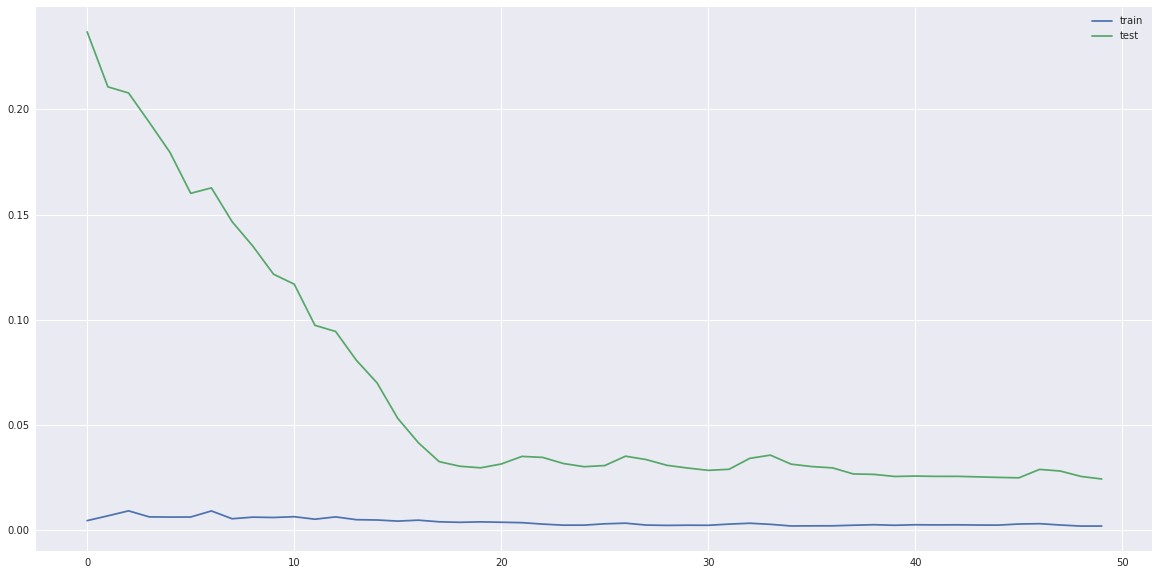

In [44]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=9, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [45]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

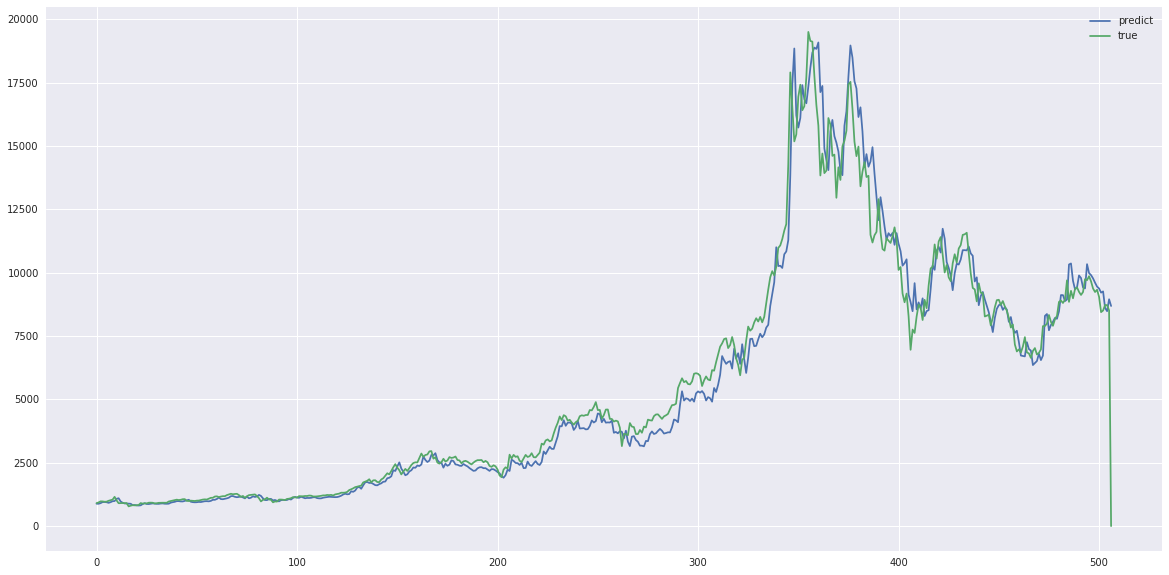

In [46]:
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 20,10

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

In [47]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 835.856


In [48]:
inv_yhat

array([  882.64148056,   881.35201848,   905.18451431,   946.57237581,
         949.7599685 ,   941.46900258,   917.41962319,   943.20835641,
         981.30584885,   988.27953406,  1076.35343325,  1098.89791968,
         972.30169485,   921.58900256,   895.16312849,   889.63811794,
         881.77358316,   881.23449751,   827.44999029,   831.15545966,
         817.83738567,   811.63085523,   819.31184521,   868.4514417 ,
         902.65803152,   871.85185047,   869.0162396 ,   884.17963966,
         895.22385008,   884.64994141,   878.22137043,   877.80932073,
         889.96344328,   894.45604161,   882.10079697,   880.13010552,
         884.04040129,   923.9658604 ,   943.79174848,   957.63307403,
         984.83743368,   985.16304955,   973.43760976,   972.08147015,
         992.97049441,  1014.31217049,  1038.42394204,   961.7037445 ,
         944.36715087,   938.81962395,   942.04789138,   954.00241714,
         948.29480604,   964.17647853,   980.76029882,   982.44612178,
      

In [49]:
inv_y

array([  907.61,   933.2 ,   975.92,   973.5 ,   961.24,   963.74,
         998.33,  1021.75,  1043.84,  1154.73,  1013.38,   902.2 ,
         908.59,   911.2 ,   902.83,   907.68,   777.76,   804.83,
         823.98,   818.41,   821.8 ,   831.53,   907.94,   886.62,
         899.07,   895.03,   921.79,   924.67,   921.01,   892.69,
         901.54,   917.59,   919.75,   921.59,   919.5 ,   920.38,
         970.4 ,   989.02,  1011.8 ,  1029.91,  1042.9 ,  1027.34,
        1038.15,  1061.35,  1063.07,   994.38,   988.67,  1004.45,
         999.18,   990.64,  1004.55,  1007.48,  1027.44,  1046.21,
        1054.42,  1047.87,  1079.98,  1115.3 ,  1117.44,  1166.72,
        1173.68,  1143.84,  1165.2 ,  1179.97,  1179.97,  1222.5 ,
        1251.01,  1274.99,  1255.15,  1267.12,  1272.83,  1223.54,
        1150.  ,  1188.49,  1116.72,  1175.83,  1221.38,  1231.92,
        1240.  ,  1249.61,  1187.81,  1100.23,   973.82,  1036.74,
        1054.23,  1120.54,  1049.14,  1038.59,   937.52,   972

In [72]:
data = pd.read_csv('eth_price.csv', index_col="Date")

data.tail()

,Close,Volume,Market Cap,ETH
Date,,,,
"May 07, 2018",9373.01,7394020000,1.640000e+11,753.73
"May 08, 2018",9234.82,7415870000,1.600000e+11,752.86
"May 09, 2018",9325.18,7226890000,1.570000e+11,752.28
"May 10, 2018",9043.94,6906700000,1.590000e+11,727.28
"May 11, 2018",0.00,0,0.000000e+00,0.00


In [73]:
#Tranform the date field

data.index = pd.to_datetime(data.index)
print(data.index)
data.head(5)

DatetimeIndex(['2015-08-07', '2015-08-08', '2015-08-09', '2015-08-10',
               '2015-08-11', '2015-08-12', '2015-08-13', '2015-08-14',
               '2015-08-15', '2015-08-16',
               ...
               '2018-05-02', '2018-05-03', '2018-05-04', '2018-05-05',
               '2018-05-06', '2018-05-07', '2018-05-08', '2018-05-09',
               '2018-05-10', '2018-05-11'],
              dtype='datetime64[ns]', name='Date', length=1009, freq=None)


,Close,Volume,Market Cap,ETH
Date,,,,
2015-08-07,279.59,42484800,4.032820e+09,2.770000
2015-08-08,261.00,58533000,4.048270e+09,0.753325
2015-08-09,265.08,23789600,3.779770e+09,0.701897
2015-08-10,264.47,20979400,3.843850e+09,0.708448
2015-08-11,270.39,25433900,3.828500e+09,1.070000


In [74]:
# load dataset
dataset1 = data[['ETH','Volume','Market Cap','Close']]
values = dataset1.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[5,6,7]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)
1   0.001984   0.001782   0.012371   0.014340  0.000539
2   0.000539   0.002455   0.012418   0.013386  0.000503
3   0.000503   0.000998   0.011594   0.013596  0.000507
4   0.000507   0.000880   0.011791   0.013564  0.000766
5   0.000766   0.001067   0.011744   0.013868  0.000874


In [75]:
# split into train and test sets
values = reframed.values
n_train_hours = int(len(values)*0.5)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(504, 1, 4) (504,) (504, 1, 4) (504,)


Train on 504 samples, validate on 504 samples
Epoch 1/50
 - 1s - loss: 0.0013 - val_loss: 0.2548
Epoch 2/50
 - 0s - loss: 0.0021 - val_loss: 0.2539
Epoch 3/50
 - 0s - loss: 0.0022 - val_loss: 0.2552
Epoch 4/50
 - 0s - loss: 0.0021 - val_loss: 0.2554
Epoch 5/50
 - 0s - loss: 0.0021 - val_loss: 0.2555
Epoch 6/50
 - 0s - loss: 0.0020 - val_loss: 0.2549
Epoch 7/50
 - 0s - loss: 0.0020 - val_loss: 0.2553
Epoch 8/50
 - 0s - loss: 0.0020 - val_loss: 0.2566
Epoch 9/50
 - 0s - loss: 0.0018 - val_loss: 0.2558
Epoch 10/50
 - 0s - loss: 0.0025 - val_loss: 0.2529
Epoch 11/50
 - 0s - loss: 0.0024 - val_loss: 0.2520
Epoch 12/50
 - 0s - loss: 0.0025 - val_loss: 0.2521
Epoch 13/50
 - 0s - loss: 0.0020 - val_loss: 0.2517
Epoch 14/50
 - 0s - loss: 0.0021 - val_loss: 0.2513
Epoch 15/50
 - 0s - loss: 0.0020 - val_loss: 0.2519
Epoch 16/50
 - 0s - loss: 0.0021 - val_loss: 0.2512
Epoch 17/50
 - 0s - loss: 0.0022 - val_loss: 0.2530
Epoch 18/50
 - 0s - loss: 0.0019 - val_loss: 0.2534
Epoch 19/50
 - 0s - loss: 0

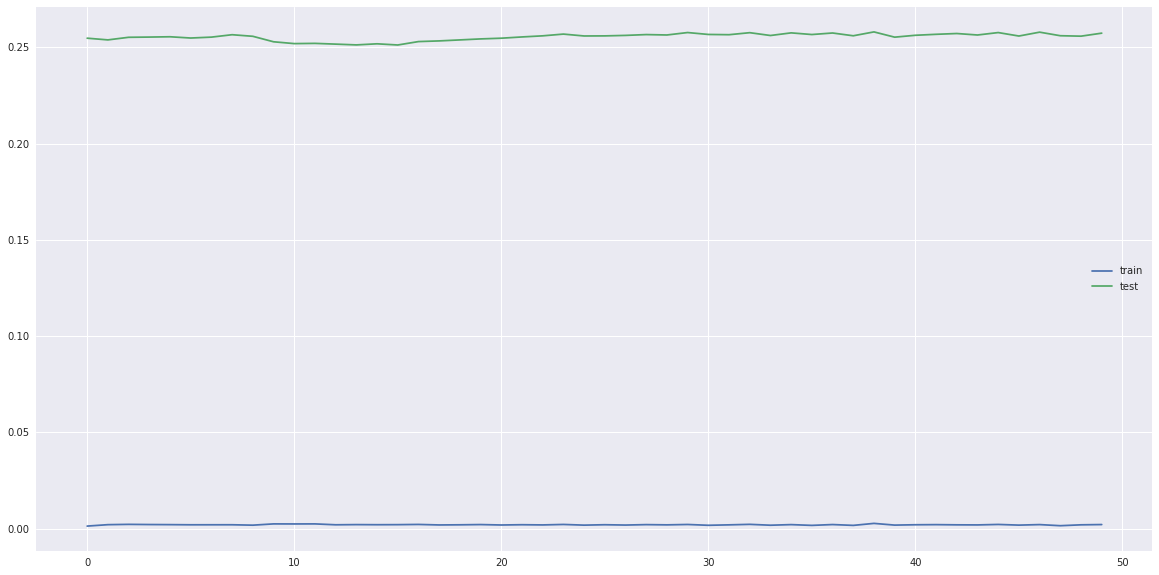

In [76]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=9, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [77]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

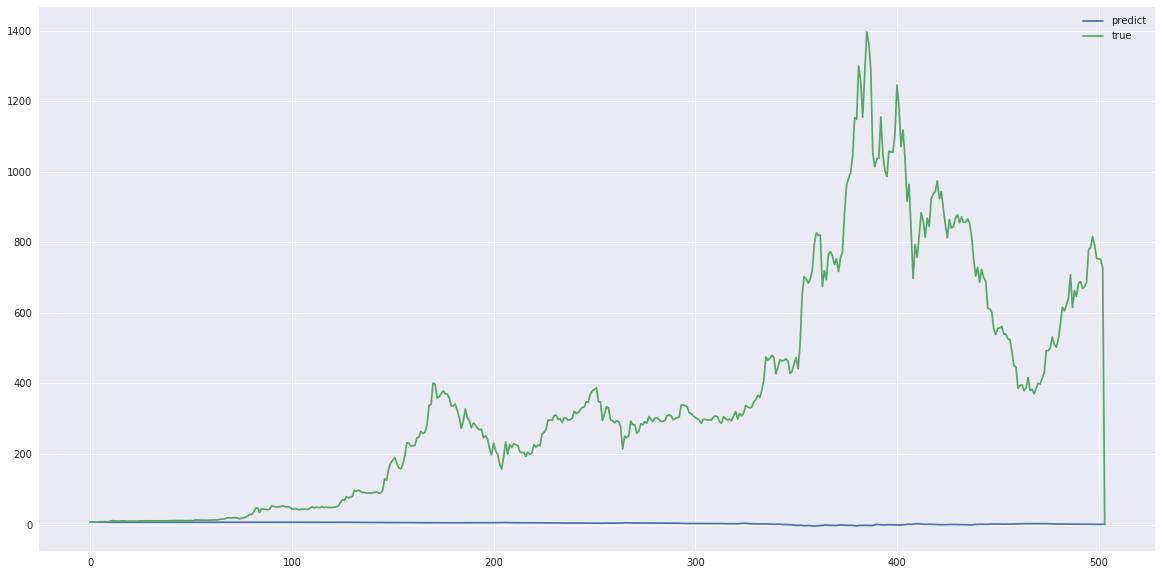

In [78]:

#Plotting the prediction
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='true')
pyplot.legend()
pyplot.show()

In [79]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 482.515


In [81]:
inv_yhat

array([ 6.88751061,  6.86615481,  6.87451584,  6.86894507,  6.86006579,
        6.84191642,  6.82609627,  6.83056225,  6.82512413,  6.81532343,
        6.80268696,  6.78178114,  6.7455045 ,  6.7828157 ,  6.85234071,
        6.87662072,  6.86217263,  6.86215702,  6.86069199,  6.9279593 ,
        6.94868045,  6.92800287,  6.91677745,  6.91506077,  6.91177956,
        6.88573865,  6.8771923 ,  6.8671432 ,  6.8636097 ,  6.85598866,
        6.8477746 ,  6.84390816,  6.86289506,  6.86608263,  6.85785686,
        6.85173272,  6.84519632,  6.84466636,  6.84635638,  6.8349671 ,
        6.81162671,  6.79672408,  6.78816993,  6.77243302,  6.77095693,
        6.77103041,  6.76172066,  6.7598206 ,  6.80502334,  6.80697736,
        6.79457108,  6.78883124,  6.79673904,  6.79419393,  6.78437957,
        6.77944281,  6.7684814 ,  6.75472647,  6.75356186,  6.74672959,
        6.73107656,  6.71498916,  6.69972954,  6.69387981,  6.68711842,
        6.68299123,  6.67151806,  6.67075596,  6.65647108,  6.64